## Identifications

---

### Imports

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from matplotlib.patches import Rectangle
from tqdm import tqdm
from scipy.stats import cumfreq
from collections import Counter
from lmfit import Model
from scipy.stats import binned_statistic
from functools import partial
from astropy.constants import c
utils.rcparams()

In [2]:
# Load the Herschel, COSMOS2020 and matched VLA data sets
herschel = utils.full_loader('Herschel')
cosmos2020 = utils.full_loader('COSMOS2020')
vla = utils.full_loader('VLA_COSMOS2020_05')

# Add redshift errors to VLA data
vla['lp_zPDF_low'] = vla['lp_zPDF']-vla['lp_zPDF_l68']
vla['lp_zPDF_high'] = vla['lp_zPDF_u68']-vla['lp_zPDF']
vla['lp_zPDF_err'] = (vla['lp_zPDF_low']+vla['lp_zPDF_high'])/2

# Define the cosmology used throughout
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

/Users/bradleyward/Desktop/PhD/PhD_Projects/Thesis-Chapter-5-Radio-Sources/utils/loader.py:24: DtypeWarning: Columns (591) have mixed types. Specify dtype option on import or set low_memory=False.
  data = read_csv(file_path)


---

### Create COSMOS Survey

In [3]:
# Define parameter files for sources and counterparts
source_params = {'data': herschel,
                 'name': 'id_her',
                 'ra': 'RA_her',
                 'dec': 'Dec_her',
                 'wavelengths_obs_um': np.array([250,350,500]),
                 'fluxes': ['F_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500'],
                 'flux_errors': ['FErr_BLIND_MF_SPIRE_250', 'FErr_BLIND_MF_SPIRE_350', 'FErr_BLIND_MF_SPIRE_500']}

counterpart_params = {'data': vla,
                      'name': 'id_cos',
                      'ra': 'RA_cos',
                      'dec': 'Dec_cos',
                      'fluxes': ['total_int_flux'],
                      'redshift': 'lp_zPDF',
                      'redshift_err': 'lp_zPDF_err'}

In [4]:
# Create Herschel and VLA objects and generate COSMOS survey
herschel_objects, vla_objects = utils.create_sources_and_counterparts(source_params, counterpart_params)
cosmos = utils.Survey(herschel_objects, vla_objects)
print('Region being used: RA - {:.3f} to {:.3f}, DEC - {:.3f} to {:.3f}'.format(cosmos.ra_min, cosmos.ra_max, cosmos.dec_min, cosmos.dec_max))
print('Area of Overlapping Region = {:.2f} deg2'.format(cosmos.area_deg))

Creating Sources:   3%|▎         | 343/11185 [00:00<00:03, 3427.60it/s]

Creating Counterparts: 100%|██████████| 10830/10830 [00:01<00:00, 8185.67it/s]

Input Number of Sources = 11185
Input Number of Counterparts = 10830
Overlapping Number of Sources = 7230 (64.64%)
Overlapping Number of Counterparts = 10826 (99.96%)
Region being used: RA - 149.289 to 150.952, DEC - 1.452 to 3.038
Area of Overlapping Region = 2.64 deg2


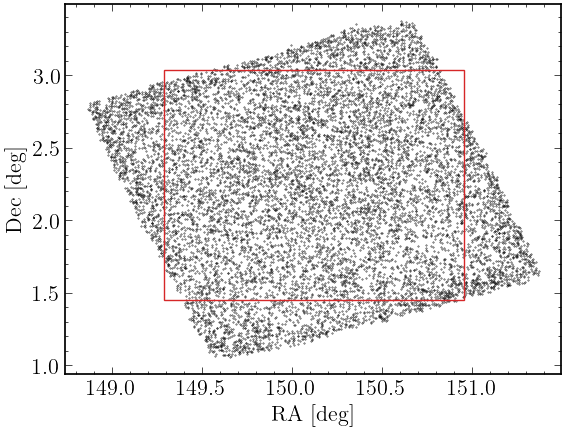

In [5]:
# Obtain location of Herschel objects
herschel_ras = [herschel_objects[it].ra for it in range(len(herschel_objects))]
herschel_decs = [herschel_objects[it].dec for it in range(len(herschel_objects))]

fig, ax = plt.subplots()
ax.scatter(herschel_ras, herschel_decs, s=0.1)
ax.add_patch(Rectangle((cosmos.ra_min, cosmos.dec_min), cosmos.ra_max-cosmos.ra_min, cosmos.dec_max-cosmos.dec_min, edgecolor='tab:red', facecolor='none'))
ax.set_xlabel(r'RA [deg]')
ax.set_ylabel(r'Dec [deg]')
plt.savefig(utils.ROOT+'/figures/Figure_5_1.pdf', dpi=1000)
plt.show()

---

### Defining the Optimal Search Radius

In [6]:
# Define the number of random sources to create
N = len(cosmos.sources)
r_max_arcsec = 30
rand_sources = utils.random_sources(N, cosmos.ra_min, cosmos.ra_max, cosmos.dec_min, cosmos.dec_max)

# Set up arrays for radial separations
rand_r = []
herschel_r = []

# For all possible candidates around random sources append their separation
for source in tqdm(rand_sources, desc='Random Sources'):
    r_max_deg = r_max_arcsec/3600
    ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
    possible_counterparts = [counterpart for counterpart in cosmos.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
    for counterpart in possible_counterparts:
        r = counterpart.separation(source)
        if r <= r_max_arcsec:
            rand_r.append(r)

# For all possible candidates around Herschel sources append their separation
for source in tqdm(cosmos.sources, desc='Herschel Sources'):
    r_max_deg = r_max_arcsec/3600
    ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
    possible_counterparts = [counterpart for counterpart in cosmos.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
    for counterpart in possible_counterparts:
        r = counterpart.separation(source)
        if r <= r_max_arcsec:
            herschel_r.append(r)

# Generate histograms of separations
rand_r_hist, bin_edges = np.histogram(rand_r, bins=30, range=(0,30))
herschel_r_hist, _ = np.histogram(herschel_r, bins=30, range=(0,30))
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

# Generate cumulative frequency arrays from separations
rand_r_cum = cumfreq(rand_r, 30, defaultreallimits=(0,30))
herschel_r_cum = cumfreq(herschel_r, 30, defaultreallimits=(0,30))
rand_r_freq = np.array(rand_r_cum.cumcount)
herschel_r_freq = np.array(herschel_r_cum.cumcount)

Herschel Sources: 100%|██████████| 7230/7230 [00:04<00:00, 1548.00it/s]


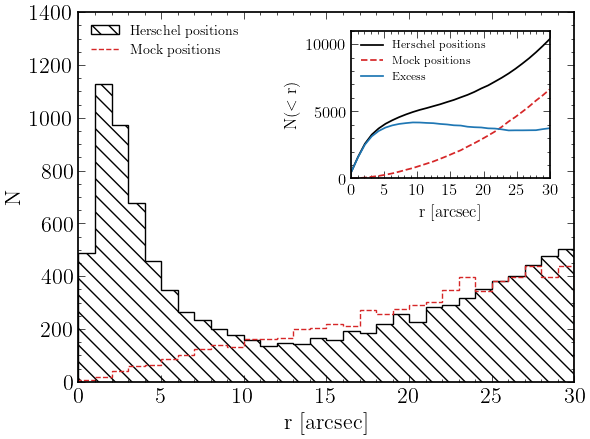

In [7]:
r_range = np.linspace(0,30,30)

# Plot of radial separations and cumulative counts
fig, ax = plt.subplots()
ax.stairs(herschel_r_hist, bin_edges, hatch=r'\\', label=r'Herschel positions')
ax.stairs(rand_r_hist, bin_edges, linestyle='--', label=r'Mock positions', color='tab:red')

axin = ax.inset_axes([0.55,0.55,0.4,0.4])
axin.plot(r_range, herschel_r_freq, label=r'Herschel positions')
axin.plot(r_range, rand_r_freq, linestyle='--', color='tab:red', label=r'Mock positions')
axin.plot(r_range, herschel_r_freq-rand_r_freq, color='tab:blue', label=r'Excess')
axin.set_xlabel(r'r [arcsec]', fontsize=12)
axin.set_ylabel(r'N($<$ r)', fontsize=12)
axin.tick_params(axis='both', labelsize=12)
axin.set_xticks([0,5,10,15,20,25,30])
axin.set_xlim(0,30)
axin.set_ylim(0,11000)
axin.legend(fontsize=8)

ax.set_xlim(0,30)
ax.set_ylim(0,1400)
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.legend(loc='upper left', fontsize=10)
plt.savefig(utils.ROOT+'/figures/Figure_5_2.pdf', dpi=1000)
plt.show()

---

### Estimate of the Maximum P Value

Expected maximum P based on Poisson statistics:
Let X be the number of VLA sources observed within a single search radius

$$\lambda = N_{\textrm{VLA}}A_{\textrm{Circle}}/A_{\textrm{Survey}}$$

\begin{align}
    P_{\textrm{max}} &\sim \frac{P(\textrm{Not-blank})}{P(\textrm{Blank})} \\
    &= \frac{P(X > 0)}{P(X = 0)} \\
    &= \frac{1-P(X = 0)}{P(X = 0)} \\
    &= \frac{1-e^{-\lambda}}{e^{-\lambda}}
\end{align}

In [8]:
# Expected maximum P value (ignoring overlapping regions and assuming Poisson statistics)
r_max = 10
N_vla = len(cosmos.counterparts)
a_circle = np.pi*(r_max**2)
a_survey = cosmos.area_arcsec
lam = (N_vla*a_circle)/a_survey
prob_max = (1-np.exp(-lam))/(np.exp(-lam))
print('The number density of VLA objects = {:.2f} per square degree'.format(N_vla/cosmos.area_deg))
print('The maximum probability is expected to be approximately = {:.2f}'.format(prob_max))

The number density of VLA objects = 4103.01 per square degree
The maximum probability is expected to be approximately = 0.10


---

### Creating COSMOS Sample

In [12]:
# Defining maximum r and P values and generating D(S) distributions
r_max = 10
p_max = 0.05
herschel_ds = cosmos.get_s_values(r_max_arcsec=r_max)
random_ds, herschel_vla = cosmos.get_groups(r_max_arcsec=r_max, p_max=p_max, n=1000000)

Calculating S Values:   0%|          | 1360/1000000 [00:01<17:45, 936.85it/s]


KeyboardInterrupt: 

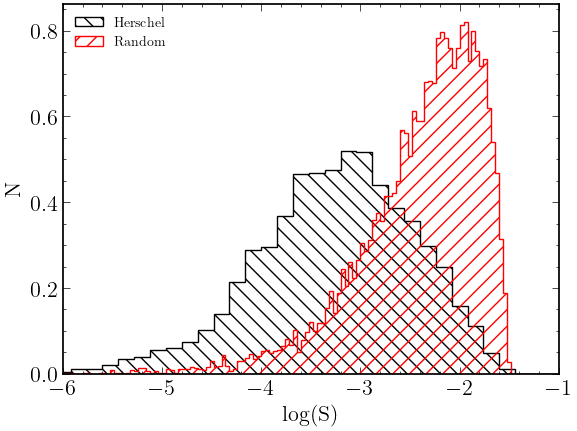

In [11]:
logs_range = (-8,0)

# Plot of the D(S) distributions
fig, ax = plt.subplots()
ax.hist(np.log10(herschel_ds), bins=50, range=logs_range, histtype='step', hatch=r'\\', label=r'Herschel', density=True)
ax.hist(np.log10(random_ds), bins=200, range=logs_range, histtype='step', hatch=r'//', label=r'Random', density=True)
ax.set_xlabel(r'log(S)')
ax.set_ylabel(r'N')
ax.set_xlim(-6,-1)
ax.legend(fontsize=10, loc='upper left')
plt.savefig(utils.ROOT+'/figures/Figure_5_3.pdf', dpi=1000)
plt.show()

In [ ]:
# Apply a flux limit on samples
flux_limit = 0.03
herschel_vla_flux = utils.apply_flux_limit(herschel_vla, flux_limit)

#### Important Statistics and ID Fraction

In [ ]:
# Number of sources and counterparts
n_sources = len(cosmos.sources)
n_counterparts = len(cosmos.counterparts)
n_sources_flux = len([source for source in cosmos.sources if source.fluxes[0] > flux_limit])

# Number of primary IDs 
n_ids = len(herschel_vla['primaries'])
n_ids_flux = len(herschel_vla_flux['primaries'])

# Number of expected false IDs
n_false = np.sum([pair.p for pair in herschel_vla['primaries']])
n_false_flux = np.sum([pair.p for pair in herschel_vla_flux['primaries']])

print('The number of Herschel sources = {}'.format(n_sources))
print('The number of VLA sources = {}'.format(n_counterparts))
print('The number of sources with IDs = {} ({:.2f}%)'.format(n_ids, (n_ids/n_sources)*100))
print('The number of false IDs to sources = {:.2f} ({:.2f}%)'.format(n_false, (n_false/n_sources)*100))

print('The number of Herschel sources > {} mJy = {}'.format(flux_limit*1000, n_sources_flux))
print('The number of sources > {} mJy with IDs = {} ({:.2f}%)'.format(flux_limit*1000, n_ids_flux, (n_ids_flux/n_sources_flux)*100))
print('The number of false IDs to sources > {} mJy = {:.2f} ({:.2f}%)'.format(flux_limit*1000, n_false_flux, (n_false_flux/n_sources_flux)*100))

# The number of IDs and number of potential candidates per source
counter_flux = Counter([len([pairs]) for pairs in herschel_vla_flux['singles']])+Counter([len(group.pairs) for group in herschel_vla_flux['multiples']])
print('The number of IDs per source > {} mJy: {}'.format(flux_limit*1000, counter_flux))
print('The average number of potential counterparts to each source = {:.2f}'.format(len(cosmos.counterparts)/len(cosmos.sources)))

In [ ]:
flux_range = np.logspace(-2.5, 0, 30)

# Obtain fluxes for all primaries, singles and multiples
all_fluxes, bin_edges = np.histogram([obj.fluxes[0] for obj in cosmos.sources], bins=flux_range)
primaries_fluxes = [pair.source.fluxes[0] for pair in herschel_vla['primaries']]
singles_fluxes = [pair.source.fluxes[0] for pair in herschel_vla['singles']]
multiples_fluxes = [group.source.fluxes[0] for group in herschel_vla['multiples']]
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

# Convert flux lists into histograms
primaries_fluxes_id = np.histogram(primaries_fluxes, bins=flux_range)[0]/all_fluxes
primaries_fluxes_id_err = np.sqrt(np.histogram(primaries_fluxes, bins=flux_range)[0])/all_fluxes
singles_fluxes_id = np.histogram(singles_fluxes, bins=flux_range)[0]/all_fluxes
multiples_fluxes_id = np.histogram(multiples_fluxes, bins=flux_range)[0]/all_fluxes

In [ ]:
# Plot of the ID fraction as a function of 250-micron flux
fig, ax = plt.subplots()
ax.stairs(primaries_fluxes_id, flux_range, label=r'All Sources', zorder=10)
ax.errorbar(bin_centers, primaries_fluxes_id, yerr=primaries_fluxes_id_err, fmt='.', c='k')
ax.stairs(singles_fluxes_id, flux_range, label=r'Sources with 1 Radio ID')
ax.stairs(multiples_fluxes_id, flux_range, label=r'Sources with $>$ 1 Radio ID')
ax.set_xlabel(r'$S_{250\mu m}$ [Jy]')
ax.set_ylabel(r'ID Fraction')
ax.set_xlim(5e-3,5e-1)
ax.set_ylim(0,1.2)
ax.semilogx()
ax.legend(loc='upper left', fontsize=10)
plt.savefig(utils.ROOT+'/figures/Figure_5_4.pdf', dpi=1000)
plt.show()

#### Determining Positional Errors

In [ ]:
# Source-counterpart offsets
primaries_sc_offset = [pair.r for pair in herschel_vla_flux['primaries']]
secondaries_sc_offset = [pair.r for pair in herschel_vla_flux['secondaries']]
tertiaries_sc_offset = [pair.r for pair in herschel_vla_flux['tertiaries']]

# Primary redshifts
primaries_z = [pair.counterpart.redshift for pair in herschel_vla_flux['primaries']]
primaries_median_z = np.nanmedian(primaries_z)

# Average source-counterpart offsets
singles_sc_offset_average = [pair.r for pair in herschel_vla_flux['singles']]
multiples_sc_offset_average = [group.average_counterpart_source_separation for group in herschel_vla_flux['multiples']]
all_sc_offset_average = singles_sc_offset_average+multiples_sc_offset_average
all_sc_offset = primaries_sc_offset+secondaries_sc_offset+tertiaries_sc_offset

# Generating histograms of source-counterpart offsets
primaries_sc_offset_hist, r_bins = np.histogram(primaries_sc_offset, bins=20, range=(0,10))
primaries_sc_offset_hist_err = np.sqrt(primaries_sc_offset_hist)
all_average_sc_offset_hist, _ = np.histogram(all_sc_offset_average, bins=20, range=(0,10))
all_sc_offset_hist, _ = np.histogram(all_sc_offset, bins=20, range=(0,10))
r_bin_centers = (r_bins[:-1] + r_bins[1:])/2

In [ ]:
# Create a model for our radial offset distribution
rmodel = Model(utils.rayleigh)
params = rmodel.make_params(A=500, sigma=2)
params['A'].vary = True
params['sigma'].vary = True
result = rmodel.fit(primaries_sc_offset_hist, params, r=r_bin_centers, weights=1/primaries_sc_offset_hist_err)

# Determine the best fitting values of parameters
A_best = result.params['A'].value
sigma_best = result.params['sigma'].value

In [ ]:
# Defining quantities for comparison with LR f(r)
sigma_lr, z_viking = 2.4, 0.49
distance_lr = utils.separation_to_distance(sigma_lr, z_viking)
sigma_lr_radio = utils.distance_to_separation(distance_lr, primaries_median_z)

r_range = np.linspace(0,10,1000)
d_range = np.linspace(0,80,1000)

# Plot of Rayleigh distributions
fig, ax = plt.subplots()
ax.stairs(primaries_sc_offset_hist, r_bins, label='Primaries', zorder=10)
ax.errorbar(r_bin_centers, primaries_sc_offset_hist, yerr=primaries_sc_offset_hist_err, fmt='.', c='k')
ax.stairs(all_average_sc_offset_hist, r_bins, color='k', linestyle='--',  label='Average Radio Position')
ax.stairs(all_sc_offset_hist, r_bins, color='k', linestyle=':',  label='All Radio IDs')
ax.plot(r_range, rayleigh(r_range, A_best, sigma_best), c='r', label=r'Rayleigh (Primaries)')
ax.plot(r_range, rayleigh(r_range, A_best, sigma_lr), c='g', label=r'Rayleigh ($\sigma$ = 2.4", $\bar{z}$ = 0.49)')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.set_xlim(0,10)
ax.legend(fontsize=10)
plt.savefig(utils.ROOT+'/figures/Figure_5_5.pdf', dpi=1000)
plt.show()

In [ ]:
# Best fitting value of the positional error
print('The width of the Rayleigh distribution = {:.2f}'.format(sigma_best))
print('Sigma = {:.2f} (z = {:.2f}) scales to {:.2f} (z = {:.2f})'.format(sigma_lr, z_viking, sigma_lr_radio, primaries_median_z))

#### Multiple Systems - Fluxes

In [ ]:
# Ordered fluxes for primaries, secondaries and tertiaries
flux_ordered = [group.counterpart_flux_sorted for group in herschel_vla['multiples']]
first_flux = [list_[0] for list_ in flux_ordered]
second_flux = [list_[1] for list_ in flux_ordered]
third_flux = [list_[2] for list_ in flux_ordered]

# Contribution of primaries, secondaries and tertiaries to total flux
flux_contributions = [group.counterpart_flux_contribution() for group in herschel_vla['multiples']]
first_contribution = [list_[0] for list_ in flux_contributions]
second_contribution = [list_[1] for list_ in flux_contributions]
third_contribution = [list_[2] for list_ in flux_contributions]
source_fluxes = [group.source.fluxes[0]*1000 for group in herschel_vla['multiples']]

# Determine bins of equal width
def create_equal_width_bins(x, n_bins):
    """
    Returns an array in N bins of equal number

    :param x: Array of input values
    :param n_bins: Number of bins created
    :return: Equally sized bins
    """
    split_array = np.array_split(np.sort(x), n_bins)
    equal_bins = [split_array[0][0]]+[split_array[it][-1] for it in range(n_bins)]
    return equal_bins

equal_width_bins = create_equal_width_bins(source_fluxes, 5)

# Determine the median (with errors) contribution in equal bin widths
first_contribution_average, bin_edges, _ = binned_statistic(source_fluxes, first_contribution, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 50))
first_contribution_low, _, _ = binned_statistic(source_fluxes, first_contribution, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 16))
first_contribution_high, _, _ = binned_statistic(source_fluxes, first_contribution, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 84))

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

In [ ]:
alpha = 0.75

# Plot of radio flux contribution from primaries, secondaries and tertiaries
fig, ax = plt.subplots()
ax.scatter(source_fluxes, first_contribution, alpha=0.25, s=10, label=r'Radio Brightest')
markers, caps, bars = ax.errorbar(bin_centers, first_contribution_average, xerr=(np.diff(bin_edges)/2), yerr=(first_contribution_average-first_contribution_low, first_contribution_high-first_contribution_average), mfc='grey', fmt='o')
[bar.set_alpha(alpha) for bar in bars]
[cap.set_alpha(alpha) for cap in caps]
ax.axhline(np.nanmedian(second_contribution), c='tab:red', alpha=0.5, label=r'Average Second Brightest')
ax.axhline(np.nanmedian(third_contribution), c='tab:blue', alpha=0.5, label=r'Average Third Brightest')
ax.set_xlabel(r'$S_{\small 250\,\mu m}$ [mJy]')
ax.set_ylabel(r'Fraction of $S_{\small 3\,\textrm{GHz}}$')
ax.set_ylim(0, 1)
ax.semilogx()
ax.legend(handlelength=0, markerscale=0, fontsize=12, labelcolor=['k', 'tab:red', 'tab:blue'], loc='lower right')
plt.subplots_adjust(hspace=0)
plt.savefig(utils.ROOT+'/figures/Figure_5_6.pdf', dpi=1000)
plt.show()

#### Multiple Systems - Projected Separation and Redshifts

In [ ]:
# Counterpart-Counterpart redshift differences
multiples_cc_zdiff = list(chain.from_iterable([obj.counterpart_counterpart_z_difference()[0] for obj in herschel_vla_flux['multiples']]))
multiples_cc_zdiff_err = list(chain.from_iterable([obj.counterpart_counterpart_z_difference()[1] for obj in herschel_vla_flux['multiples']]))

# Counterpart-counterpart offsets
multiples_cc_offsets = list(chain.from_iterable([obj.counterpart_counterpart_separations() for obj in herschel_vla_flux['multiples']]))

alpha = 0.25

# Plot of the counterpart-counterpart separations and redshift differences
fig, ax = plt.subplots()
markers, caps, bars = ax.errorbar(multiples_cc_zdiff, multiples_cc_offsets, xerr=multiples_cc_zdiff_err, markerfacecolor='gray', fmt='o', markersize=4)
[bar.set_alpha(alpha) for bar in bars]
[cap.set_alpha(alpha) for cap in caps]

ax.tick_params(axis='y', which='both', right=False)
secax = ax.secondary_yaxis('right', functions=(partial(utils.separation_to_distance, z=primaries_median_z), partial(utils.distance_to_separation, z=primaries_median_z)))
secax.set_ylabel(r'D [kpc] (z = {:.2f})'.format(primaries_median_z))

ax.set_xlim(0,2)
ax.set_ylim(0,15)
ax.set_xlabel(r'$\Delta$z')
ax.set_ylabel(r'r [arcsec]')
plt.savefig(utils.ROOT+'/figures/Figure_5_7.pdf', dpi=1000)
plt.show()

#### Missing IDs

In [ ]:
# The number of sources without secure IDs
n_blanks_or_nonsig = len(herschel_vla_flux['blanks'])
percentage_blanks_or_nonsig = (n_blanks_or_nonsig/n_sources_flux)*100
print('The number of sources with no IDs (or non-significant associations) = {} ({:.2f}%)'.format(n_blanks_or_nonsig), (percentage_blanks_or_nonsig))

In [ ]:
def colour(wave_obs_um_1, wave_obs_um_2, z, t, beta):
    """
    Returns the colour from a given SED
    
    :param wave_obs_um_1: First observed wavelength [microns]
    :param wave_obs_um_2: Second observed wavelength [microns]
    :param z: Redshift
    :param t: Dust temperature [K]
    :param beta: Dust emissivity spectral index
    :return: 
    """

    # Convert observed wavelengths to rest frame frequencies.
    wave_obs_m_1, wave_obs_m_2 = wave_obs_um_1*1e-6, wave_obs_um_2*1e-6
    wave_rest_m_1, wave_rest_m_2 = wave_obs_m_1/(1+z), wave_obs_m_2/(1+z)
    nu_rest_1, nu_rest_2 = c.value/wave_rest_m_1, c.value/wave_rest_m_2

    # Calculate colour from SED
    colour = utils.mbb(nu_rest_1, 1, t, beta)/utils.mbb(nu_rest_2, 1, t, beta)
    return colour

# Colours of blanks sources
blanks_250_350 = [blank.fluxes[0]/blank.fluxes[1] for blank in herschel_vla_flux['blanks']]
blanks_500_350 = [blank.fluxes[2]/blank.fluxes[1] for blank in herschel_vla_flux['blanks']]

# Colours of primary IDs
primaries_250_350 = [obj.source.fluxes[0]/obj.source.fluxes[1] for obj in herschel_vla_flux['primaries']]
primaries_500_350 = [obj.source.fluxes[2]/obj.source.fluxes[1] for obj in herschel_vla_flux['primaries']]

In [ ]:
z_range = np.linspace(0,4,100)

# Plot of far-IR colours of blanks and primary IDs
fig, ax = plt.subplots()
ax.scatter(primaries_250_350, primaries_500_350, alpha=0.25, s=5, label=r'Sources with IDs')
ax.scatter(blanks_250_350, blanks_500_350, alpha=0.25, s=5, label='Blanks')
ax.plot(colour(250, 350, z_range, 30, 2), colour(500, 350, z_range, 30, 2), alpha=0.75, label=r'MBB [T = 30\,K, $\beta$ = 2]')
ax.text(colour(250, 350, 0, 30, 2)-0.1, colour(500, 350, 0, 30, 2)-0.05, r'$z = 0$', fontsize=9)
ax.text(colour(250, 350, 1, 30, 2)-0.15, colour(500, 350, 1, 30, 2)-0.075, r'$z = 1$', fontsize=9)
ax.text(colour(250, 350, 2, 30, 2)-0.25, colour(500, 350, 2, 30, 2)-0.05, r'$z = 2$', fontsize=9)
ax.text(colour(250, 350, 3, 30, 2)-0.225, colour(500, 350, 3, 30, 2)-0.05, r'$z = 3$', fontsize=9)
ax.text(colour(250, 350, 4, 30, 2)-0.225, colour(500, 350, 4, 30, 2)-0.05, r'$z = 4$', fontsize=9)
ax.scatter(colour(250, 350, np.array([0,0.5,1,1.5,2,2.5,3,3.5,4]), 30, 2), colour(500, 350, np.array([0,0.5,1,1.5,2,2.5,3,3.5,4]), 30, 2), c='k')
ax.set_xlabel(r'$S_{250}/S_{350}$')
ax.set_ylabel(r'$S_{500}/S_{350}$')
ax.set_xlim(0,3.25)
ax.set_ylim(0,1.4)
ax.legend(fontsize=10, loc='lower left', markerscale=1)
plt.savefig(utils.ROOT+'/figures/Figure_5_8.pdf', dpi=1000)
plt.show()

In [ ]:
# The effects of increasing the maximum P to 0.1 to find missing IDs
_, herschel_vla_p01 = cosmos.get_groups(r_max_arcsec=r_max, p_max=0.1, n=100000)
herschel_vla_flux_p01 = utils.apply_flux_limit(herschel_vla_p01, flux_limit)
print('Number of blank sources if we allow P < 0.1 = {} (Down by {})'.format(len(herschel_vla_flux_p01['blanks']), len(herschel_vla_flux['blanks']) - len(herschel_vla_flux_p01['blanks'])))

---